In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import itertools
from noise_filter import *

# Path to the images
img_folder_noisy = "../Data/Week3/qsd1_w3/"  # Update this path as necessary
img_folder_gt = "../Data/Week3/qsd1_w3/non_augmented/"  # Update this path as necessary
list_noisy_img = [f for f in os.listdir(img_folder_noisy) if f.endswith('.jpg')]
list_gt_img = [f for f in os.listdir(img_folder_gt) if f.endswith('.jpg')]
list_noisy_img.sort()
list_gt_img.sort()

In [2]:
# Create a list that stores 1 if the image has noise, 0 if not.
pkl_path="../Data/Week3/qsd1_w3/augmentations.pkl"
with open(pkl_path, "rb") as f:
    data = pickle.load(f)
    
noise_label=[]
for label in data:
    if label == "UnnamedImpulseNoise":
        noise_label.append(1)
    else:
        noise_label.append(0)
print(noise_label)

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]


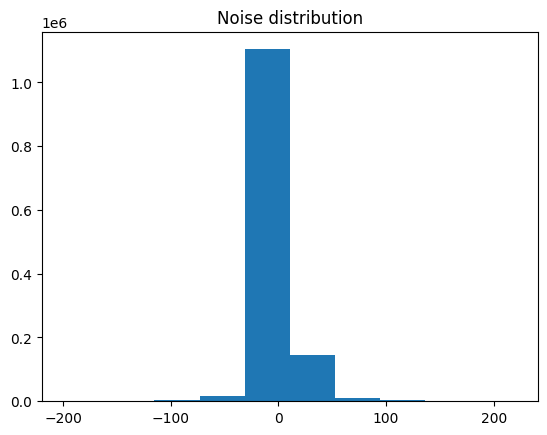

46.66834707880374
20.691383653342594
13.627963492072778


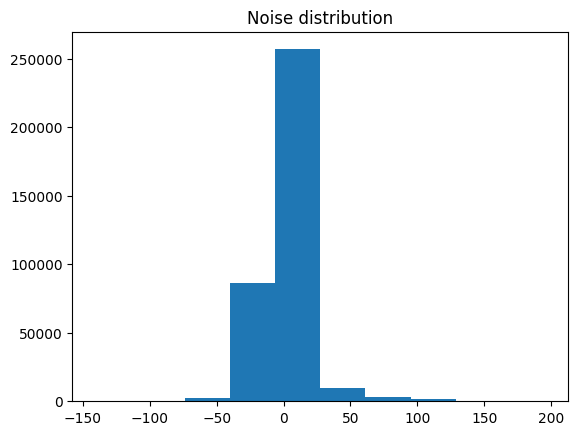

54.03848474472748
30.005198197336764
24.37589964914011


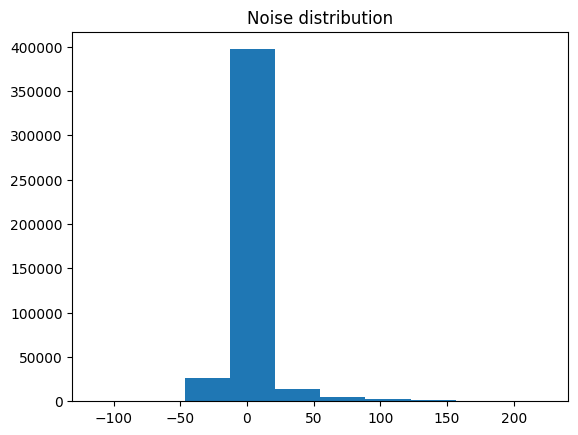

56.66138690925736
24.69770112978101
16.457153103320863


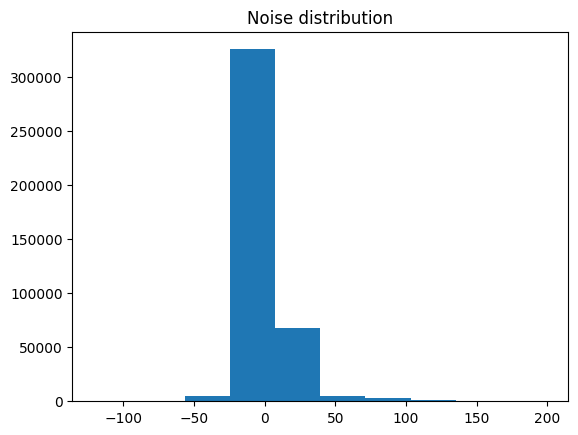

62.791410035127996
34.25261080556463
20.17662517513449


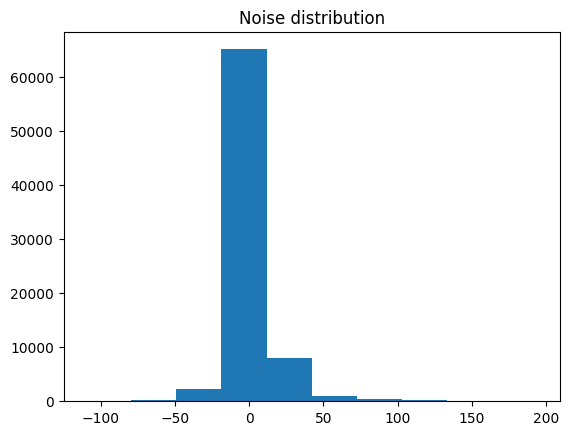

51.37151479289662
23.94577672878812
19.371760259989955


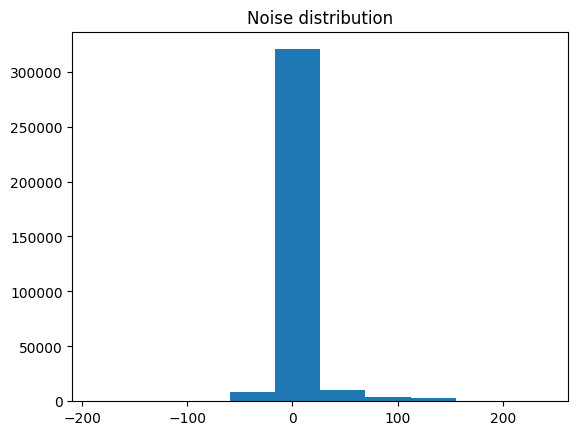

48.20663526028463
19.45410851553458
14.912247220791834


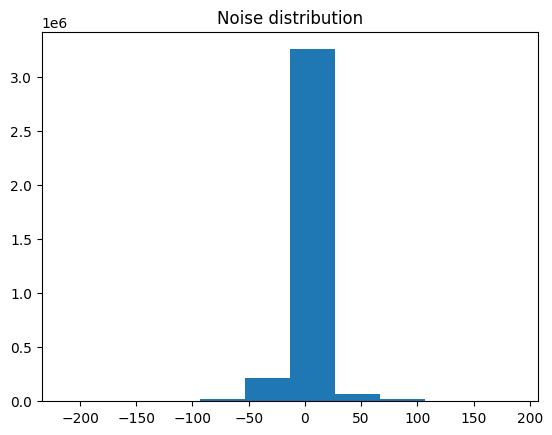

52.08290956313697
22.61441306727685
11.898007766494157


In [3]:
# List to store noise scores calculated in the frequency space
noise_score = []

for i_noisy, i_gt, n_label in zip(list_noisy_img, list_gt_img, noise_label):
    noisy_img = cv2.imread(os.path.join(img_folder_noisy, i_noisy))
    gt_img = cv2.imread(os.path.join(img_folder_gt, i_gt))
    
    noise_score.append(fourier_noise_score(noisy_img, radius_ratio=0.75))
    if n_label:
        analyze_noise(noisy_img, gt_img)
        print(fourier_noise_score(noisy_img, radius_ratio=0.75))
        denoised_img=remove_noise_median(noisy_img, ksize=3)
        print(fourier_noise_score(denoised_img, radius_ratio=0.75))
        denoised_img=remove_noise_nlmeans(denoised_img, h=5, templateWindowSize=3, searchWindowSize=21)
        print(fourier_noise_score(denoised_img, radius_ratio=0.75))

In [4]:
# Now, threshold the noise_score to know which images have noise.
# For those with noise, perform the noise filter algorithm.
THRESHOLD = 40
mse_list, ssim_list = [], []
for score, n_img_path, gt_img_path in zip(noise_score, list_noisy_img, list_gt_img):
    if score > THRESHOLD:
        noisy_img = cv2.imread(os.path.join(img_folder_noisy, n_img_path))
        gt_img = cv2.imread(os.path.join(img_folder_gt, gt_img_path))
        #print(classify_noise_type(noisy_img)
        denoised_img=remove_noise_median(noisy_img, ksize=3)
        denoised_img=remove_noise_bilateral(denoised_img, d=21, sigmaColor=25, sigmaSpace=50)
        #denoised_img=remove_noise_nlmeans(denoised_img, h=5, templateWindowSize=3, searchWindowSize=21)
        # Calculate PSNR and SSIM
        m, ssim_val = evaluate_denoising(denoised_img, gt_img)
        print(mse_to_psnr(m), ssim_val)
        mse_list.append(m)
        ssim_list.append(ssim_val)
        cv2.imshow("", noisy_img)
        cv2.waitKey(0)
        cv2.imshow("",denoised_img)
        cv2.waitKey(0)
#mean_mse = np.mean(mse_list)
#mean_ssim = np.mean(ssim_list)
#print(mean_mse, mean_ssim)

31.18993027675177 0.8620777834244011
23.575893170522075 0.631534574788837
33.31366087886906 0.8424414918310852
38.79620709085182 0.9444089111271458
30.614204450710233 0.8456324135342669
32.968806657220895 0.8603947986824106
34.52758288470293 0.8979368774914492


In [5]:
# Define of parameters for grid search
"""h_values = [3, 5, 10]
template_sizes = [3, 5, 7]
search_sizes = [11, 15, 21]"""

d_values = [11, 15, 21]
sigmaColor_values = [25, 50, 100]
sigmaSpace_values = [50, 100, 200]

ksize=[3]

THRESHOLD = 40

results = []

#param_grid = list(itertools.product(h_values, template_sizes, search_sizes, ksize))
param_grid = list(itertools.product(d_values, sigmaColor_values, sigmaSpace_values, ksize))

for h, t, s, k in param_grid:
    mse_list, ssim_list = [], []

    for score, n_img_path, gt_img_path in zip(noise_score, list_noisy_img, list_gt_img):
        if score > THRESHOLD:
            noisy_img = cv2.imread(os.path.join(img_folder_noisy, n_img_path))
            gt_img = cv2.imread(os.path.join(img_folder_gt, gt_img_path))

            denoised_img = remove_noise_median(noisy_img, ksize=k)
            #denoised_img = remove_noise_nlmeans(denoised_img, h=h, templateWindowSize=t, searchWindowSize=s)
            denoised_img = remove_noise_bilateral(denoised_img, d=h, sigmaColor=t, sigmaSpace=s)
            
            
            m, ssim_val = evaluate_denoising(denoised_img, gt_img)
            mse_list.append(m)
            ssim_list.append(ssim_val)

    mean_mse = np.mean(mse_list)
    mean_ssim = np.mean(ssim_list)
    mean_psnr = mse_to_psnr(mean_mse)

    results.append({
        'h': h,
        'template': t,
        'search': s,
        'ksize': k,
        'mean_mse': mean_mse,
        'mean_ssim': mean_ssim,
        'mean_psnr': mean_psnr
    })

results_sorted = sorted(results, key=lambda x: (x['mean_psnr'], x['mean_ssim']), reverse=True)
best = results_sorted[0]

print("\nGrid search results:")
for r in results_sorted:
    print(f"h={r['h']}, template={r['template']}, search={r['search']}, ksize={r['ksize']} → "
          f"PSNR={r['mean_psnr']:.2f}, SSIM={r['mean_ssim']:.3f}")

print("\nBest set of parameters:")
print(f"h={best['h']}, template={best['template']}, search={best['search']}, ksize={r['ksize']}")
print(f"PSNR mean={best['mean_psnr']:.2f}, SSIM mean={best['mean_ssim']:.3f}")




Grid search results:
h=15, template=25, search=50, ksize=3 → PSNR=29.72, SSIM=0.840
h=15, template=25, search=100, ksize=3 → PSNR=29.72, SSIM=0.840
h=15, template=25, search=200, ksize=3 → PSNR=29.72, SSIM=0.840
h=21, template=25, search=50, ksize=3 → PSNR=29.72, SSIM=0.841
h=21, template=25, search=100, ksize=3 → PSNR=29.72, SSIM=0.841
h=21, template=25, search=200, ksize=3 → PSNR=29.71, SSIM=0.841
h=11, template=25, search=50, ksize=3 → PSNR=29.67, SSIM=0.837
h=11, template=25, search=100, ksize=3 → PSNR=29.67, SSIM=0.837
h=11, template=25, search=200, ksize=3 → PSNR=29.67, SSIM=0.837
h=11, template=50, search=50, ksize=3 → PSNR=28.96, SSIM=0.802
h=11, template=50, search=100, ksize=3 → PSNR=28.96, SSIM=0.802
h=11, template=50, search=200, ksize=3 → PSNR=28.96, SSIM=0.802
h=15, template=50, search=50, ksize=3 → PSNR=28.86, SSIM=0.798
h=15, template=50, search=100, ksize=3 → PSNR=28.86, SSIM=0.798
h=15, template=50, search=200, ksize=3 → PSNR=28.86, SSIM=0.798
h=21, template=50, sear

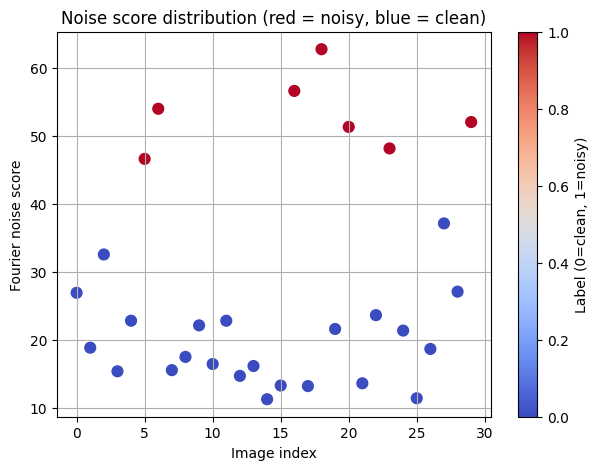

In [6]:
noise_score = np.array(noise_score)
noise_label = np.array(noise_label) 

plt.figure(figsize=(7,5))
plt.scatter(range(len(noise_score)), noise_score, c=noise_label, cmap='coolwarm', s=60)
plt.xlabel("Image index")
plt.ylabel("Fourier noise score")
plt.title("Noise score distribution (red = noisy, blue = clean)")
plt.colorbar(label="Label (0=clean, 1=noisy)")
plt.grid(True)
plt.show()
